# Задание 2

## Описание данных

Пришло время проанализировать результаты эксперимента, который мы провели вместе с командой дата сайентистов. Эксперимент проходил с 2024-09-27 по 2024-10-03 включительно. Для эксперимента были задействованы 2 и 1 группы. 

В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 

Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 

**Задача** — проанализировать данные А/B-теста. 

**Ход действий:**

1. Выбрать метод анализа и сравнить CTR в двух группах (t-тест, Пуассоновский бутстреп, тест Манна-Уитни, t-тест на сглаженном ctr (α=5) а также t-тест и тест Манна-Уитни поверх бакетного преобразования).

2. Сравнить данные этими тестами. Посмотрить на распределения глазами. Почему тесты сработали именно так?

3. Описать потенциальную ситуацию, когда такое изменение могло произойти. 

4. Написать рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит. 

## Основная часть работы

Импортируем все необходимые библиотеки.

In [1]:
import swifter
import hashlib
import pandas as pd
import pandahouse as ph
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

Подключимся к базе данных.

In [2]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20241020'
}

Отберем из базы данных интересующие нас группы и время проведения эксперимента, а также посчитаем лайки, просмотры и ctr. Сохраним результат в датафрейм df.

In [3]:
q= """
SELECT exp_group,
        user_id,
        sum(action='like') as likes, 
        sum(action='view') as views,
        likes/views as ctr
FROM simulator_20241020.feed_actions
WHERE toDate(time) BETWEEN '2024-09-27' AND '2024-10-03' 
      AND exp_group IN (1,2)
GROUP BY  exp_group, user_id    
"""
df = ph.read_clickhouse(q, connection=connection)

Выведем первые пять строк датафрейма df.

In [4]:
df.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,39,141,0.276596
4,1,18392,7,32,0.218750


Посчитаем количество человек в каждой группе.

In [5]:
df.groupby('exp_group')['user_id'].nunique()

exp_group
1    10020
2     9877
Name: user_id, dtype: int64

У нас примерно одинаковое количество пользователей в группе 1 и 2.

Проверим при помощи гистограммы, что пользователи в наших группах статистически эквивалентны, а иммено что показатель ctr имеет приблизительно одинакового значения в двух группах.

Для начала изменим размер графика. 

In [8]:
sns.set(rc={'figure.figsize':(12,10)})

Построим график, на котором отобразим значения ctr по оси x, количество таких ctr по оси y для каждой группы отдельно, чтобы увидеть схожесть или различие между группами.

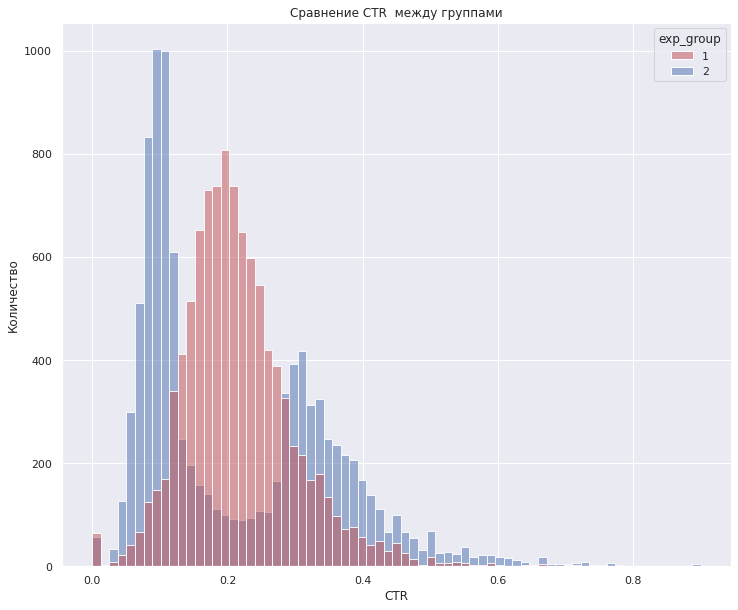

In [9]:
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)
plt.title('Сравнение CTR  между группами')
plt.xlabel('CTR')
plt.ylabel('Количество');

Распределения ctr в группах получились очень разные. В группе 1 распределение имеет вид нормального, одномодального, а в группе 2 наблюдаем два горба т.е. распределение бимодальное и имеется небольшой перекос в правую сторону (есть выбросы). Получается, что пользователи на группы были разделены не совсем верно.

Так как распределения у нас носят разный характер, то использовать t-тест будет неверно. Но для наглядности и выводов можно его провести.

**t-критерий Стьюдента**

Выберем уровень α = 0.05.

In [10]:
stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.4051491913112757, pvalue=0.685373331140751)

Значение pvalue > α, следовательно наш t-тест не нашел никаких различий между группами.

Так как наглядно мы выявили различия в распределение ctr между группами, то и t-тест должен был зафиксировать их. Как ранее уже говрилось, распределения ctr в группах у нас носят разный характер: в группе 1 распределение одномодальное, а в группе 2 - бимодальное и имеются выбросы, поэтому t-тест не годится для наших данных.

**Тест Манна-Уитни**

У нас есть две выборки с разными респределениями. Нам нужно проверить следующее: если мы возьмем значение ctr из одной выборки и значение ctr из другой выборки (случайное), то вероятность того, что первое значение будет больше второго, равна вероятности, что второе значение будет больше первого.

Уровень α у нас такой же, равен 0.05.

In [11]:
stats.mannwhitneyu(df[df.exp_group == 1].ctr, 
                   df[df.exp_group == 2].ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=55189913.0, pvalue=4.632205841806026e-45)

Значение pvalue < α, следовательно тест Манна-Уитни нашел различия между распределениями ctr между группами.

**Бутстреп**

**1.**
* Возьмем выборку из группы 1 (user_id с его views и clicksc).
* Из распределения Пуассона генерируем «сколько раз этот пользователь попал в псевдовыборку». Получается колонка, отражающая «вес» пользователя. 
* Считаем глобальный ctr по псевдовыборке для группы 1. 

**2.** 
* Возьмем выборку из группы 2 (user_id с его views и clicks).
* Из распределения Пуассона генерируем «сколько раз этот пользователь попал в псевдовыборку». Получается колонка, отражающая «вес» пользователя. 
* Считаем глобальный ctr по псевдовыборке для группы 2.

**3.**
Считаем разницу между ctr

**4.**
Повторяем процедуру 2000 раз

Напишем функцию и проделаем все то, что описано выше.

In [12]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

Отделим лайки и просмотры для группы 1 и 2.

In [13]:
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

Получим распределение глобальных ctr.

In [14]:
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

Построим на одном графике гистограммы распределения глобальных ctr.

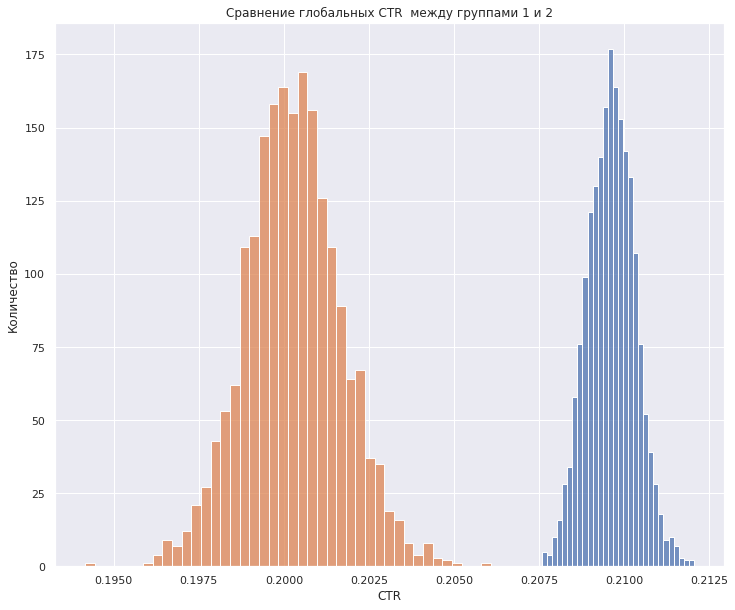

In [15]:
sns.histplot(ctr1)
sns.histplot(ctr2)
plt.title('Сравнение глобальных CTR  между группами 1 и 2')
plt.xlabel('CTR')
plt.ylabel('Количество');

Распределение глобальных ctr групп 1 и 2 не пересекается между собой.

Построим распределение разницы ctr с помощью гистограммы.

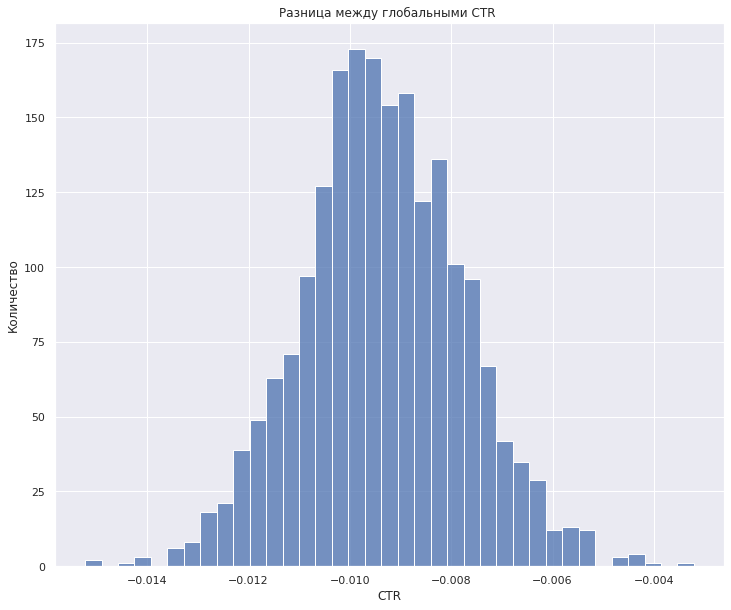

In [16]:
sns.histplot(ctr2 - ctr1)
plt.title('Разница между глобальными CTR ')
plt.xlabel('CTR')
plt.ylabel('Количество');

Гистограмма разницы ctr не превышает ноль, а это значит, что одна группа больше другой. Разница между распределениями отрицательная, а значит, что с помощью бустрепа мы можем утверждать, что группа 1 показала лучшие результаты чем группа 2.

**Бакетное преобразование**

Поделим нашу исходную выборку на 50 бакетов и посчитаем в каждом бакете 90% квантиль ctr и средний ctr, чтобы получить выборку из 50-ти значений 90% квантиля ctr и 50-ти значений среднего ctr по этим «метапользователям».  

Отберем из базы данных интересующие нас группы и время проведения эксперимента, а также посчитаем лайки, просмотры, а также бакетный ctr и значения 90% квантиля ctr. Сохраним результат в датафрейм df_1.

In [17]:
p = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM simulator_20241020.feed_actions 
    WHERE toDate(time) between '2024-09-27' AND '2024-10-03' 
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df_1 = ph.read_clickhouse(p, connection=connection)

Выведем 5 строк датафрейма df_1.

In [18]:
df_1.head()

,exp_group,bucket,bucket_ctr,ctr9
0,1,0,0.200592,0.305556
1,2,0,0.196510,0.385321
2,1,1,0.208799,0.311111
3,2,1,0.210375,0.485714
4,1,2,0.204632,0.314286


Поверх бакетного преобразования, применим тест Манна-Уитни, так как проведя наглядное сравнение групп, тест Манна-Уитни и бутстреп мы убедились в различии групп 1 и 2 и том, что распределение их ctr  носит разный характер.

Сначала посмотрим на бакетный ctr.

In [19]:
stats.mannwhitneyu(df_1[df_1.exp_group == 1].bucket_ctr, 
                   df_1[df_1.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1997.0, pvalue=2.6576427804010095e-07)

Значение pvalue < α, следовательно тест Манна-Уитни нашел различия между распределениями бакетных ctr между группами 1 и 2.

Построим гистограммы бакетных ctr отдельно для группы 1 и 2.

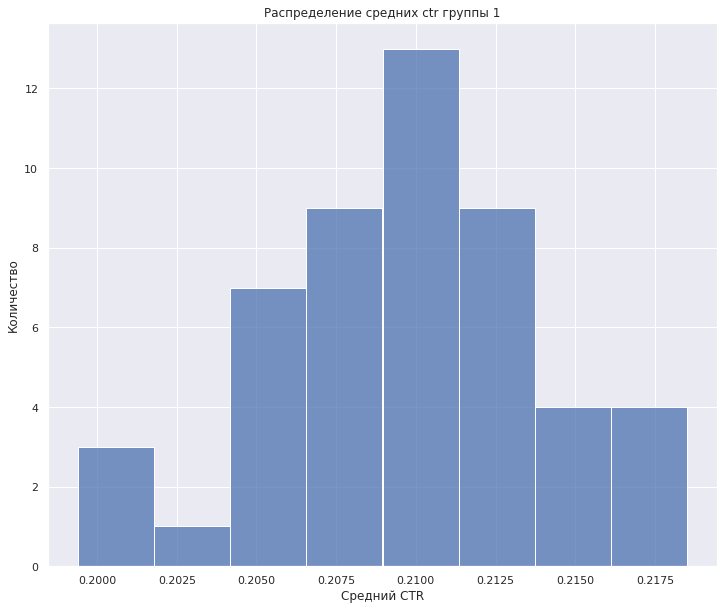

In [20]:
sns.histplot(df_1[df_1.exp_group == 1].bucket_ctr)
plt.title('Распределение средних ctr группы 1')
plt.xlabel('Средний CTR')
plt.ylabel('Количество');

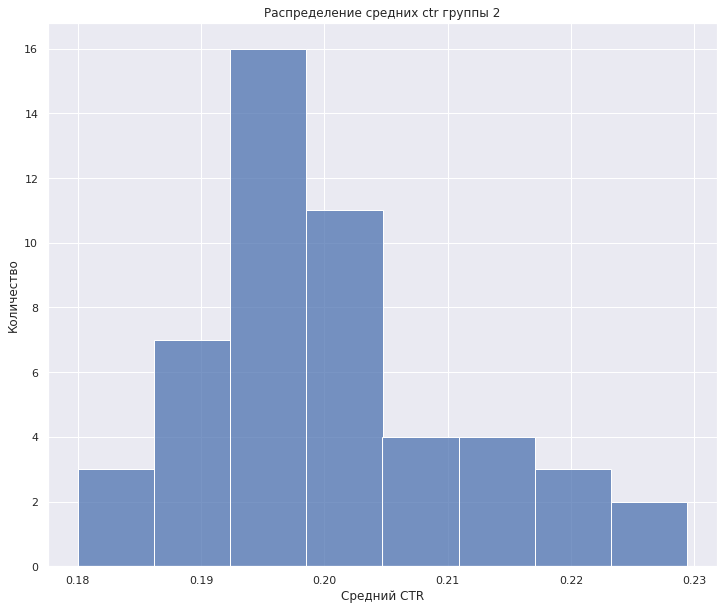

In [21]:
sns.histplot(df_1[df_1.exp_group == 2].bucket_ctr)
plt.title('Распределение средних ctr группы 2')
plt.xlabel('Средний CTR')
plt.ylabel('Количество');

Распределение бакетных ctr напоминает нормальное, но скошено в разные стороны.

Проверим 90% квантиль ctr между группами 1 и 2.

In [22]:
stats.mannwhitneyu(df_1[df_1.exp_group == 1].ctr9, 
                   df_1[df_1.exp_group == 2].ctr9, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=0.0, pvalue=6.7601631082665925e-18)

Значение pvalue < α, следовательно тест Манна-Уитни нашел различия между распределениями 90% квантиля ctr между группами 1 и 2.

Построим гистограммы 90% квантиля ctr отдельно для группы 1 и 2.

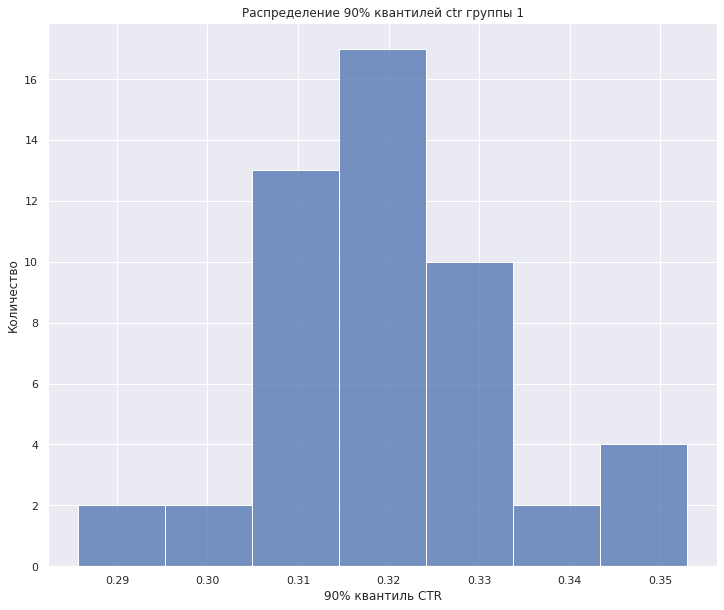

In [23]:
sns.histplot(df_1[df_1.exp_group == 1].ctr9)
plt.title('Распределение 90% квантилей ctr группы 1')
plt.xlabel('90% квантиль CTR')
plt.ylabel('Количество');

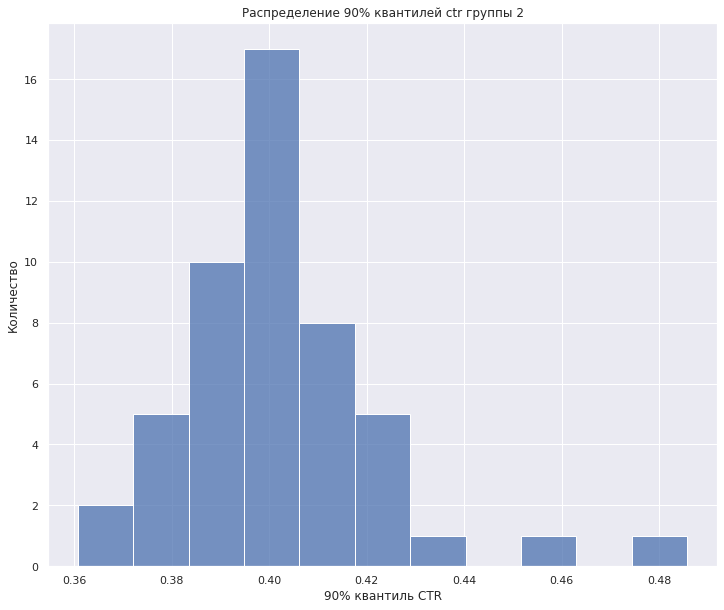

In [24]:
sns.histplot(df_1[df_1.exp_group == 2].ctr9)
plt.title('Распределение 90% квантилей ctr группы 2')
plt.xlabel('90% квантиль CTR')
plt.ylabel('Количество');

Распределение 90% квантиля ctr в группе 1 немного напоминает нормальное, в группе 2 оно тоже похоже на нормальное, но имеет ряд выбросов. Распределения не похожи между собой.

## Выводы и рекомендации

Проведя наглядное сравнение групп, и воспользовавшись различными статистическими тестами, приходим к выводу, что группа 1 и 2 имеют статистически значимые отличия. Причем у контрольной группы показатели лучше, чем у тестовой. Я бы не рекомендовала использовать новый алгоритм рекомендации постов. Возможно пользователи были разбиты на группы неправильно, из-за чего эксперимет стал провальным, а возможно пользователям не понравился новый алгоритм рекомендации постов, что скорее более верно. 